In [1]:
#imports
import pandas as pd 
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time
import matplotlib.pyplot as plt

import nba_api
from nba_api.stats.static import teams, players
from nba_api.stats.endpoints import playercareerstats, leaguegamefinder, playerdashboardbyclutch, playergamelogs, commonplayerinfo, teamplayeronoffdetails, teamgamelogs


In [68]:
class Team(object):
    def __init__(self, TeamID):
        
        self.TeamID =  TeamID 
        self.TeamName = teams.find_team_name_by_id(team_id=self.TeamID)['full_name']

        self.StartYear = 2009 #First year data is avalible
        self.LastYear = 2021 #Current year
        
        
        #team abreviations and corresponding codes for data proccessing
        self.team_abbreviation_codes = {
            "ATL": 1,
            "BKN": 2,
            "BOS": 3,
            "CHA": 4,
            "CHI": 5,
            "CLE": 6,
            "DAL": 7,	
            "DEN": 8,
            "DET": 9,
            "GSW": 10,	
            "HOU": 11,	
            "IND": 12,
            "LAC": 13,	
            "LAL": 14,	
            "MEM": 15, 	
            "MIA": 16,	
            "MIL": 17,	
            "MIN": 18,	
            "NOP": 19,
            "NOH": 19,	
            "NYK": 20,	
            "OKC": 21,	
            "ORL": 22,	
            "PHI": 23,	
            "PHX": 24,	
            "POR": 25,	
            "SAC": 26,	
            "SAS": 27,	
            "TOR": 28,	
            "UTA": 29,	
            "WAS": 30
        }

        
    #Complile the Team Data
    def compile_active_team_data(self):
        

        matchup_raw_data = []
    
        team_season_point_average_raw_data = []
        team_points_raw_data = []
        opponent_season_point_average_raw_data = []
        opponent_season_points_raw_data = []
        
        team_season_FT_average_raw_data = []
        team_season_FG_average_raw_data = []
        team_season_FG3_average_raw_data = []
        opponent_season_FT_average_raw_data = []
        opponent_season_FG_average_raw_data = []
        opponent_season_FG3_average_raw_data = []
            
        
        print(self.StartYear, self.LastYear)
        for year in range((self.StartYear), (self.LastYear)):
            print("-------------------------------------------------")
            season = str(year) + "-" + str(((year+1)-2000))
            teamLogs = teamgamelogs.TeamGameLogs(team_id_nullable=self.TeamID, season_nullable=season)
            print(season)
            

            matchup_api_data = teamLogs.get_data_frames()[0]["MATCHUP"]
            team_season_points_api_data=teamLogs.get_data_frames()[0]["PTS"]
        

            print(teamLogs.get_data_frames()[0])


            team_season_points = []
            
            
            for game in range(0, len(teamLogs.get_data_frames()[0])):
        
                        
                    self.team_abbreviation = teams.find_team_name_by_id(team_id=self.TeamID)['abbreviation']
                    

                    try:   
                        
                        matchup_api_data[game] = matchup_api_data[game].replace(self.team_abbreviation, "")
                        
                    except:
                        print("Unexpected Error with removing player team")
                    try:
                        matchup_api_data[game] = matchup_api_data[game].replace(" @ ", "")
                        matchup_api_data[game] = matchup_api_data[game].replace(" vs. ", "")
                    except:
                        print("Error")
                    
                    
                    
                    opponentAbbreviation = matchup_api_data[game]
                    
                    matchup_api_data[game] = matchup_api_data[game].replace('NOH', 'NOP')
                    matchup_api_data[game] = matchup_api_data[game].replace('NJN', 'BKN')
                    
                    opponentAbbreviation_for_search = matchup_api_data[game]
                    
                    matchup_api_data[game] = self.team_abbreviation_codes[matchup_api_data[game]]
                    
                    matchup_raw_data.append(matchup_api_data[game])
                    
                    opponentID = int(teams.find_team_by_abbreviation(opponentAbbreviation_for_search)["id"])
                    if (game%10==0):
                        print(game)
                        
                    opponentLogs = teamgamelogs.TeamGameLogs(team_id_nullable=opponentID, season_nullable=season)
                    opponent_season_points_api_data = opponentLogs.get_data_frames()[0]['PTS']
                    
                    
                    team_points_raw_data.append(team_season_points_api_data[game])
                    team_season_points.append(team_season_points_api_data[game])
                    past_games = teamLogs.get_data_frames()[0].head(game+1).copy()
                    team_season_FT_average_raw_data.append(past_games.loc[past_games['MATCHUP'].isin(["{} @ {}".format(self.team_abbreviation, opponentAbbreviation),"{} vs. {}".format(self.team_abbreviation, opponentAbbreviation)])]["FTM"].mean())
                    team_season_FG_average_raw_data.append(past_games.loc[past_games['MATCHUP'].isin(["{} @ {}".format(self.team_abbreviation, opponentAbbreviation),"{} vs. {}".format(self.team_abbreviation, opponentAbbreviation)])]["FGM"].mean())
                    team_season_FG3_average_raw_data.append(past_games.loc[past_games['MATCHUP'].isin(["{} @ {}".format(self.team_abbreviation, opponentAbbreviation),"{} vs. {}".format(self.team_abbreviation, opponentAbbreviation)])]["FG3M"].mean())
                    
                    past_opponent_games = opponentLogs.get_data_frames()[0].head(game+1).copy()
                    opponent_season_FT_average_raw_data.append(past_opponent_games.loc[past_games['MATCHUP'].isin(["{} @ {}".format(opponentAbbreviation, self.team_abbreviation),"{} vs. {}".format(opponentAbbreviation, self.team_abbreviation)])]["FTM"].mean())
                    opponent_season_FG_average_raw_data.append(past_opponent_games.loc[past_games['MATCHUP'].isin(["{} @ {}".format(opponentAbbreviation, self.team_abbreviation),"{} vs. {}".format(opponentAbbreviation, self.team_abbreviation)])]["FGM"].mean())
                    opponent_season_FG3_average_raw_data.append(past_opponent_games.loc[past_games['MATCHUP'].isin(["{} @ {}".format(opponentAbbreviation, self.team_abbreviation),"{} vs. {}".format(opponentAbbreviation, self.team_abbreviation)])]["FG3M"].mean())
                    if game == 0:
                        opponent_season_point_average_raw_data.append(opponent_season_points_api_data[game])
                        team_season_point_average_raw_data.append(teamLogs.get_data_frames()[0]["PTS"][game])
                        
                        
                    elif game<(len(opponentLogs.get_data_frames()[0]['PTS'])):
                        opponent_season_point_average_raw_data.append(opponent_season_points_api_data.head(game).mean())
                        team_season_point_average_raw_data.append((sum(team_season_points)/len(team_season_points)))
                        
                        
                        #print(1111, self.team_abbreviation)
                        #print(opponentAbbreviation)
                        #print(222, "{} @ {}".format(self.team_abbreviation, opponentAbbreviation) )
                        #print(past_games.loc[past_games["MATCHUP"]=="NYK vs. WAS"])
                        #print(past_games.loc[past_games['MATCHUP'].isin(["{} @ {}".format(self.team_abbreviation, opponentAbbreviation),"{} vs. {}".format(self.team_abbreviation, opponentAbbreviation)])])
                        #print(55555555555555555, past_games.loc[past_games['MATCHUP'].isin(["{} @ {}".format(self.team_abbreviation, opponentAbbreviation),"{} vs. {}".format(self.team_abbreviation, opponentAbbreviation)])]["FTM"])
                        #print(past_games.loc[past_games['MATCHUP'].isin(["{} @ {}".format(self.team_abbreviation, opponentAbbreviation),"{} vs. {}".format(self.team_abbreviation, opponentAbbreviation)])]["FTM"].mean())
                        
                        
                    else:
                        opponent_season_point_average_raw_data.append(opponent_season_points_api_data.mean())
                        team_season_point_average_raw_data.append((sum(team_season_points)/len(team_season_points)))
                    
                                            
                    time.sleep(1)
                    

        #Lengths of lists used for troublshooting
        print("the lengths")
        print(len(team_points_raw_data))
        print(len(matchup_raw_data))
        print(len(team_season_point_average_raw_data))
        print(len(opponent_season_point_average_raw_data))
        print(len(team_season_FT_average_raw_data)) 
        print(len(team_season_FG_average_raw_data)) 
        print(len(team_season_FG3_average_raw_data)) 
        print(len(opponent_season_FT_average_raw_data))
        print(len(opponent_season_FG_average_raw_data)) 
        print(len(opponent_season_FG3_average_raw_data)) 
        #adding the lists to the team data dictionary to be made into a dataframe
        team_data = {
        "Points Scored": team_points_raw_data,
        "Matchup": matchup_raw_data,
        "Team Point Average" : team_season_point_average_raw_data,
        "Opponent Team Point Average": opponent_season_point_average_raw_data, 
        "Team Season FTM Average Specific": team_season_FT_average_raw_data,
        "Team Sesason FGM Average Specific": team_season_FG_average_raw_data,
        "Team Season FG3M Average Specific": team_season_FG3_average_raw_data,
        "Opponent Season FTM Average Specific": opponent_season_FT_average_raw_data,
        "Opponent Season FGM Average Specific": opponent_season_FG_average_raw_data,
        "Opponent Season FG3M Average Specific": opponent_season_FG3_average_raw_data 
        }

        team_dataFrame = pd.DataFrame(data=team_data)
        print(team_dataFrame) #print for troublshooting

        return(team_dataFrame)


    def process_active_team_data(self,data_for_processing):
        data = data_for_processing
        opponent_processing = data.pop('Matchup')

        data["ATL"] = (opponent_processing == 1)*1.0
        data["BKN"] = (opponent_processing == 2)*1.0
        data["BOS"] = (opponent_processing == 3)*1.0
        data["CHA"] = (opponent_processing == 4)*1.0
        data["CHI"] = (opponent_processing == 5)*1.0
        data["CLE"] = (opponent_processing == 6)*1.0
        data["DAL"] = (opponent_processing == 7)*1.0
        data["DEN"] = (opponent_processing == 8)*1.0
        data["DET"] = (opponent_processing == 9)*1.0
        data["GSW"] = (opponent_processing == 10)*1.0
        data["HOU"] = (opponent_processing == 11)*1.0
        data["IND"] = (opponent_processing == 12)*1.0
        data["LAC"] = (opponent_processing == 13)*1.0
        data["LAL"] = (opponent_processing == 14)*1.0
        data["MEM"] = (opponent_processing == 15)*1.0
        data["MIA"] = (opponent_processing == 16)*1.0
        data["MIL"] = (opponent_processing == 17)*1.0
        data["MIN"] = (opponent_processing == 18)*1.0
        data["NOP"] = (opponent_processing == 19)*1.0
        data["NYK"] = (opponent_processing == 20)*1.0
        data["OKC"] = (opponent_processing == 21)*1.0
        data["ORL"] = (opponent_processing == 22)*1.0
        data["PHI"] = (opponent_processing == 23)*1.0
        data["PHX"] = (opponent_processing == 24)*1.0
        data["POR"] = (opponent_processing== 25)*1.0
        data["SAC"] = (opponent_processing == 26)*1.0
        data["SAS"] = (opponent_processing == 27)*1.0
        data["TOR"] = (opponent_processing == 28)*1.0
        data["UTA"] = (opponent_processing == 29)*1.0
        data["WAS"] = (opponent_processing == 30)*1.0		


        data = data.drop(columns=[self.team_abbreviation])

        return(data)
       
    #Get the Team data for outside calls
    def get_active_team_data(self):
        compiled_data = self.compile_active_team_data()
        return(self.process_active_team_data(compiled_data))
    def compile_data_for_prediction(self, opponentAbbreviation_for_prediction):
        print(22222)
        season = "2020-21"
        teamLogs = teamgamelogs.TeamGameLogs(team_id_nullable=self.TeamID, season_nullable=season)
        team_season_points_api_data = teamLogs.get_data_frames()[0]["PTS"]
        print(team_season_points_api_data)
        team_season_point_average = [team_season_points_api_data.mean()]
        
        print(77777777777777777777777777777777777777777, team_season_point_average)
        opponentID = int(teams.find_team_by_abbreviation(opponentAbbreviation_for_prediction)["id"])
        opponentLogs = teamgamelogs.TeamGameLogs(team_id_nullable=opponentID, season_nullable=season)
        opponent_season_points_api_data = opponentLogs.get_data_frames()[0]["PTS"]
        opponent_season_point_average = [opponent_season_points_api_data.mean()]

        opponent_code = self.team_abbreviation_codes[opponentAbbreviation_for_prediction]
        
        prediction_data = {
        "Matchup": [opponent_code],
        "Team Point Average" : team_season_point_average,
        "Opponent Team Point Average": opponent_season_point_average
        }
        prediction_dataframe = pd.DataFrame(data=prediction_data)
        
        print(prediction_dataframe)
        return(prediction_dataframe)
        
    def get_data_for_prediction(self, opponentAbbreviation_for_prediction):
        compiled_data = self.compile_data_for_prediction(opponentAbbreviation_for_prediction)
        print("Here is the result", )
        return(self.process_active_team_data(compiled_data))
    



In [69]:
team =Team(1610612752) 
test = team.get_active_team_data() 




    


print(test)




2009 2021
-------------------------------------------------
2009-10
   SEASON_YEAR     TEAM_ID TEAM_ABBREVIATION        TEAM_NAME     GAME_ID  \
0      2009-10  1610612752               NYK  New York Knicks  0020901226   
1      2009-10  1610612752               NYK  New York Knicks  0020901206   
2      2009-10  1610612752               NYK  New York Knicks  0020901199   
3      2009-10  1610612752               NYK  New York Knicks  0020901174   
4      2009-10  1610612752               NYK  New York Knicks  0020901158   
..         ...         ...               ...              ...         ...   
77     2009-10  1610612752               NYK  New York Knicks  0020900064   
78     2009-10  1610612752               NYK  New York Knicks  0020900047   
79     2009-10  1610612752               NYK  New York Knicks  0020900034   
80     2009-10  1610612752               NYK  New York Knicks  0020900019   
81     2009-10  1610612752               NYK  New York Knicks  0020900009   

       

10
20
30
40
50
60
-------------------------------------------------
2012-13
   SEASON_YEAR     TEAM_ID TEAM_ABBREVIATION        TEAM_NAME     GAME_ID  \
0      2012-13  1610612752               NYK  New York Knicks  0021201218   
1      2012-13  1610612752               NYK  New York Knicks  0021201202   
2      2012-13  1610612752               NYK  New York Knicks  0021201196   
3      2012-13  1610612752               NYK  New York Knicks  0021201182   
4      2012-13  1610612752               NYK  New York Knicks  0021201174   
..         ...         ...               ...              ...         ...   
77     2012-13  1610612752               NYK  New York Knicks  0021200104   
78     2012-13  1610612752               NYK  New York Knicks  0021200071   
79     2012-13  1610612752               NYK  New York Knicks  0021200042   
80     2012-13  1610612752               NYK  New York Knicks  0021200037   
81     2012-13  1610612752               NYK  New York Knicks  0021200020   


10
20
30
40
50
60
70
80
-------------------------------------------------
2015-16
   SEASON_YEAR     TEAM_ID TEAM_ABBREVIATION        TEAM_NAME     GAME_ID  \
0      2015-16  1610612752               NYK  New York Knicks  0021501212   
1      2015-16  1610612752               NYK  New York Knicks  0021501202   
2      2015-16  1610612752               NYK  New York Knicks  0021501180   
3      2015-16  1610612752               NYK  New York Knicks  0021501169   
4      2015-16  1610612752               NYK  New York Knicks  0021501151   
..         ...         ...               ...              ...         ...   
77     2015-16  1610612752               NYK  New York Knicks  0021500063   
78     2015-16  1610612752               NYK  New York Knicks  0021500048   
79     2015-16  1610612752               NYK  New York Knicks  0021500034   
80     2015-16  1610612752               NYK  New York Knicks  0021500019   
81     2015-16  1610612752               NYK  New York Knicks  00215000

10
20
30
40
50
60
70
80
-------------------------------------------------
2018-19
   SEASON_YEAR     TEAM_ID TEAM_ABBREVIATION        TEAM_NAME     GAME_ID  \
0      2018-19  1610612752               NYK  New York Knicks  0021801223   
1      2018-19  1610612752               NYK  New York Knicks  0021801213   
2      2018-19  1610612752               NYK  New York Knicks  0021801204   
3      2018-19  1610612752               NYK  New York Knicks  0021801184   
4      2018-19  1610612752               NYK  New York Knicks  0021801166   
..         ...         ...               ...              ...         ...   
77     2018-19  1610612752               NYK  New York Knicks  0021800054   
78     2018-19  1610612752               NYK  New York Knicks  0021800042   
79     2018-19  1610612752               NYK  New York Knicks  0021800028   
80     2018-19  1610612752               NYK  New York Knicks  0021800018   
81     2018-19  1610612752               NYK  New York Knicks  00218000

10
20
30
40
the lengths
912
912
912
912
912
912
912
912
912
912
     Points Scored  Matchup  Team Point Average  Opponent Team Point Average  \
0              113       28          113.000000                   131.000000   
1              114       30          113.500000                    98.000000   
2               98       16          108.333333                   100.500000   
3              103       22          107.000000                   113.666667   
4              105       12          106.600000                   106.500000   
..             ...      ...                 ...                          ...   
907             83       28          104.789474                   113.621622   
908             95        6          104.538462                   102.289474   
909            130       17          105.175000                   119.410256   
910             89       23          104.780488                   115.175000   
911            107       12          104.833333         

In [70]:
backup = test.copy()
backup

,Points Scored,Team Point Average,Opponent Team Point Average,Team Season FTM Average Specific,Team Sesason FGM Average Specific,Team Season FG3M Average Specific,Opponent Season FTM Average Specific,Opponent Season FGM Average Specific,Opponent Season FG3M Average Specific,ATL,...,OKC,ORL,PHI,PHX,POR,SAC,SAS,TOR,UTA,WAS
0,113,113.000000,131.000000,20.000000,39.000000,15.0,NaN,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,114,113.500000,98.000000,21.000000,41.000000,11.0,NaN,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,98,108.333333,100.500000,25.000000,33.000000,7.0,NaN,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,103,107.000000,113.666667,17.000000,35.000000,16.0,NaN,NaN,NaN,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,105,106.600000,106.500000,15.000000,40.000000,10.0,NaN,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,83,104.789474,113.621622,16.000000,32.000000,3.0,NaN,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
908,95,104.538462,102.289474,13.666667,37.666667,11.0,NaN,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
909,130,105.175000,119.410256,18.000000,41.500000,14.5,NaN,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
910,89,104.780488,115.175000,15.500000,34.500000,8.0,NaN,NaN,NaN,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
backup = backup.drop(columns=['ATL', 'BKN','BOS', 'CHA', 'CHI', 'CLE', 'DAL', 'DEN', 'DET', 'GSW', 'HOU', 'IND','LAC', 'LAL','MEM', 'MIA', 'MIL', 'MIN', 'NOP', 'OKC', 'ORL', 'PHI','PHX', 'POR', 'SAC', 'SAS', 'TOR', 'UTA', 'WAS', 'Opponent Season FTM Average Specific','Opponent Season FGM Average Specific','Opponent Season FG3M Average Specific' ])
backup

,Points Scored,Team Point Average,Opponent Team Point Average,Team Season FTM Average Specific,Team Sesason FGM Average Specific,Team Season FG3M Average Specific
0,113,113.000000,131.000000,20.000000,39.000000,15.0
1,114,113.500000,98.000000,21.000000,41.000000,11.0
2,98,108.333333,100.500000,25.000000,33.000000,7.0
3,103,107.000000,113.666667,17.000000,35.000000,16.0
4,105,106.600000,106.500000,15.000000,40.000000,10.0
...,...,...,...,...,...,...
907,83,104.789474,113.621622,16.000000,32.000000,3.0
908,95,104.538462,102.289474,13.666667,37.666667,11.0
909,130,105.175000,119.410256,18.000000,41.500000,14.5
910,89,104.780488,115.175000,15.500000,34.500000,8.0


In [72]:
class Prediction(object):
    
    def __init__(self, data):
        self.data = data.copy()
        
    def sigmoid(self, dataframe):
        
        return((dataframe - self.train_stats['mean'])/self.train_stats['std'])
        #Defining the model
    def build_model(self):
        #below comented out portion is another model under testing
        
        input_layer=tf.keras.layers.Input(([len(self.train_dataset.keys())]))
        densel_layer = tf.keras.layers.Dense(units=1, input_shape=([len(self.train_dataset.keys())],))
        output = densel_layer(input_layer)
        model = tf.keras.Model(inputs=input_layer,outputs=output)

        model.compile(loss="mse",optimizer=tf.keras.optimizers.Adam(0.01), metrics=['mae', 'mse'])

        '''
        
        print([len(self.train_dataset.keys())])
        model = keras.Sequential([

            layers.Dense(32, activation='relu', input_shape=[len(self.train_dataset.keys())]),
            #layers.Dropout(0.05),
            #layers.Dense(128, activation=tf.nn.relu),
            layers.Dense(16, activation='relu'),
            layers.Dense(25),
            #layers.Dense(32, activation=tf.nn.relu),
            #layers.Dropout(0.05),
            #layers.Dense(32, activation=tf.nn.relu),
            #layers.Dense(8, activation='linear'),
            layers.Dense(1)
        ])

        #optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.00009)
        
        model.compile(loss='mse',
                    optimizer='adam',
                    metrics=['mae', 'mse'])
        
        '''
        return model
        
    def test_prediction_accuracy(self):
        self.train_dataset = self.data.sample(frac=0.90, random_state=0)
        self.test_dataset = self.data.drop(self.train_dataset.index)
    
        self.train_labels = self.train_dataset.pop("Points Scored")
        self.test_labels = self.test_dataset.pop("Points Scored")
        
        self.train_stats = self.train_dataset.describe()
        #self.train_stats.pop("Points Scored")
        self.train_stats = self.train_stats.transpose()
        
        normed_train_data = self.sigmoid(self.train_dataset)
        normed_test_data = self.sigmoid(self.test_dataset)

        model = self.build_model()
        model.summary()
        example_batch = normed_train_data
        print((example_batch.keys()))
        example_result = model.predict(example_batch)
        example_result

        EPOCHS = 1000
        early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=10)
        history = model.fit(normed_train_data, self.train_labels, epochs=EPOCHS, callbacks=[early_stop])

        loss, mae, mse = model.evaluate(normed_test_data, self.test_labels, verbose=0)

        print("Testing set Mean Abs Error: {:5.2f} Points Scored".format(mae))
        #make predictions and then plot them in realation to the actual values
        test_predictions = model.predict(normed_test_data).flatten()

        plt.scatter(self.test_labels, test_predictions)
        plt.xlabel("True Values [Points Scored]")
        plt.ylabel("Predictions [Points Scored]")
        plt.axis('equal')
        plt.axis('square')
        plt.xlim([60, plt.ylim()[1]])
        plt.ylim([60, plt.ylim()[1]])
        _ = plt.plot([-100,200], [-100, 200])

        print(self.test_labels)
        print(test_predictions)
    def make_prediction(self, prediction_circumstances):
        self.train_dataset = self.data.copy()
        print(self.data)
        self.train_labels = self.train_dataset.pop("Points Scored")
        
        self.train_stats = self.train_dataset.describe()
        #self.train_stats.pop("Points Scored")
        self.train_stats = self.train_stats.transpose()
        
        normed_train_data = self.sigmoid(self.train_dataset)
        normed_prediction_data = self.sigmoid(prediction_circumstances)
        model = self.build_model()
        model.summary()
        
        #following not nessicary
        example_batch = normed_train_data
        print((example_batch.keys()))
        example_result = model.predict(example_batch)
        example_result
        
        EPOCHS = 1000
        early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=15)
        history = model.fit(normed_train_data, self.train_labels, epochs=EPOCHS, callbacks=[early_stop])
        
        prediction = model.predict(normed_prediction_data).flatten()
        print(prediction)
        return(prediction)

     Points Scored  Team Point Average  Opponent Team Point Average  \
0              113          113.000000                   131.000000   
1              114          113.500000                    98.000000   
2               98          108.333333                   100.500000   
3              103          107.000000                   113.666667   
4              105          106.600000                   106.500000   
..             ...                 ...                          ...   
907             83          104.789474                   113.621622   
908             95          104.538462                   102.289474   
909            130          105.175000                   119.410256   
910             89          104.780488                   115.175000   
911            107          104.833333                   113.175000   

     Team Season FTM Average Specific  Team Sesason FGM Average Specific  \
0                           20.000000                          39.00000

26/26 [==============================] - 0s 798us/step - loss: 8368.3856 - mae: 91.0892 - mse: 8368.3856
Epoch 44/1000
26/26 [==============================] - 0s 810us/step - loss: 8287.7635 - mae: 90.6393 - mse: 8287.7635
Epoch 45/1000
26/26 [==============================] - 0s 798us/step - loss: 8306.5324 - mae: 90.7330 - mse: 8306.5324
Epoch 46/1000
26/26 [==============================] - 0s 718us/step - loss: 8190.1733 - mae: 90.1217 - mse: 8190.1733
Epoch 47/1000
26/26 [==============================] - 0s 678us/step - loss: 8232.7311 - mae: 90.3496 - mse: 8232.7311
Epoch 48/1000
26/26 [==============================] - 0s 678us/step - loss: 8162.4712 - mae: 89.9719 - mse: 8162.4712
Epoch 49/1000
26/26 [==============================] - 0s 718us/step - loss: 8063.5998 - mae: 89.4349 - mse: 8063.5998
Epoch 50/1000
26/26 [==============================] - 0s 718us/step - loss: 8083.0843 - mae: 89.5061 - mse: 8083.0843
Epoch 51/1000
26/26 [==============================] - 0s 718u

26/26 [==============================] - 0s 718us/step - loss: 5638.3870 - mae: 74.7825 - mse: 5638.3870
Epoch 112/1000
26/26 [==============================] - 0s 718us/step - loss: 5580.1093 - mae: 74.3972 - mse: 5580.1093
Epoch 113/1000
26/26 [==============================] - 0s 838us/step - loss: 5542.5172 - mae: 74.1185 - mse: 5542.5172
Epoch 114/1000
26/26 [==============================] - 0s 798us/step - loss: 5510.2786 - mae: 73.9008 - mse: 5510.2786
Epoch 115/1000
26/26 [==============================] - 0s 839us/step - loss: 5526.0555 - mae: 74.0032 - mse: 5526.0555
Epoch 116/1000
26/26 [==============================] - 0s 796us/step - loss: 5428.0375 - mae: 73.3381 - mse: 5428.0375
Epoch 117/1000
26/26 [==============================] - 0s 798us/step - loss: 5375.9425 - mae: 72.9717 - mse: 5375.9425
Epoch 118/1000
26/26 [==============================] - 0s 718us/step - loss: 5373.4495 - mae: 72.9622 - mse: 5373.4495
Epoch 119/1000
26/26 [==============================] -

26/26 [==============================] - 0s 918us/step - loss: 3476.6807 - mae: 58.6086 - mse: 3476.6807
Epoch 180/1000
26/26 [==============================] - 0s 862us/step - loss: 3501.0719 - mae: 58.7858 - mse: 3501.0719
Epoch 181/1000
26/26 [==============================] - 0s 1ms/step - loss: 3477.8190 - mae: 58.6074 - mse: 3477.8190
Epoch 182/1000
26/26 [==============================] - 0s 838us/step - loss: 3432.3168 - mae: 58.1852 - mse: 3432.3168
Epoch 183/1000
26/26 [==============================] - 0s 885us/step - loss: 3407.8565 - mae: 57.9877 - mse: 3407.8565
Epoch 184/1000
26/26 [==============================] - 0s 838us/step - loss: 3389.5818 - mae: 57.8424 - mse: 3389.5818
Epoch 185/1000
26/26 [==============================] - 0s 904us/step - loss: 3378.8289 - mae: 57.7506 - mse: 3378.8289
Epoch 186/1000
26/26 [==============================] - 0s 878us/step - loss: 3332.3609 - mae: 57.3518 - mse: 3332.3609
Epoch 187/1000
26/26 [==============================] - 0

26/26 [==============================] - 0s 831us/step - loss: 1981.3165 - mae: 44.0178 - mse: 1981.3165
Epoch 248/1000
26/26 [==============================] - 0s 839us/step - loss: 1962.8384 - mae: 43.7811 - mse: 1962.8384
Epoch 249/1000
26/26 [==============================] - 0s 743us/step - loss: 1928.8596 - mae: 43.3334 - mse: 1928.8596
Epoch 250/1000
26/26 [==============================] - 0s 798us/step - loss: 1919.7743 - mae: 43.3265 - mse: 1919.7743
Epoch 251/1000
26/26 [==============================] - 0s 838us/step - loss: 1903.4754 - mae: 43.1381 - mse: 1903.4754
Epoch 252/1000
26/26 [==============================] - 0s 878us/step - loss: 1861.8440 - mae: 42.5803 - mse: 1861.8440
Epoch 253/1000
26/26 [==============================] - 0s 758us/step - loss: 1873.8057 - mae: 42.6843 - mse: 1873.8057
Epoch 254/1000
26/26 [==============================] - 0s 759us/step - loss: 1841.5697 - mae: 42.4731 - mse: 1841.5697
Epoch 255/1000
26/26 [==============================] -

26/26 [==============================] - 0s 838us/step - loss: 928.2493 - mae: 29.7363 - mse: 928.2493
Epoch 316/1000
26/26 [==============================] - 0s 758us/step - loss: 892.6122 - mae: 29.1070 - mse: 892.6122
Epoch 317/1000
26/26 [==============================] - 0s 760us/step - loss: 892.2689 - mae: 29.1478 - mse: 892.2689
Epoch 318/1000
26/26 [==============================] - 0s 798us/step - loss: 897.0887 - mae: 29.1327 - mse: 897.0887
Epoch 319/1000
26/26 [==============================] - 0s 793us/step - loss: 881.2174 - mae: 28.9970 - mse: 881.2174
Epoch 320/1000
26/26 [==============================] - 0s 758us/step - loss: 865.4042 - mae: 28.8084 - mse: 865.4042
Epoch 321/1000
26/26 [==============================] - 0s 860us/step - loss: 845.8609 - mae: 28.3569 - mse: 845.8609
Epoch 322/1000
26/26 [==============================] - 0s 760us/step - loss: 847.1396 - mae: 28.3431 - mse: 847.1396
Epoch 323/1000
26/26 [==============================] - 0s 782us/step -

26/26 [==============================] - 0s 871us/step - loss: 324.2544 - mae: 16.8875 - mse: 324.2544
Epoch 385/1000
26/26 [==============================] - 0s 679us/step - loss: 316.2070 - mae: 16.5621 - mse: 316.2070
Epoch 386/1000
26/26 [==============================] - 0s 875us/step - loss: 308.5676 - mae: 16.4796 - mse: 308.5676
Epoch 387/1000
26/26 [==============================] - 0s 837us/step - loss: 312.2820 - mae: 16.5153 - mse: 312.2820
Epoch 388/1000
26/26 [==============================] - 0s 718us/step - loss: 295.3380 - mae: 16.0689 - mse: 295.3380
Epoch 389/1000
26/26 [==============================] - 0s 784us/step - loss: 288.8468 - mae: 15.8324 - mse: 288.8468
Epoch 390/1000
26/26 [==============================] - 0s 797us/step - loss: 290.9124 - mae: 15.9306 - mse: 290.9124
Epoch 391/1000
26/26 [==============================] - 0s 797us/step - loss: 296.6747 - mae: 15.9082 - mse: 296.6747
Epoch 392/1000
26/26 [==============================] - 0s 876us/step -

Epoch 454/1000
26/26 [==============================] - 0s 798us/step - loss: 85.6997 - mae: 7.6622 - mse: 85.6997
Epoch 455/1000
26/26 [==============================] - 0s 865us/step - loss: 81.8575 - mae: 7.5809 - mse: 81.8575
Epoch 456/1000
26/26 [==============================] - 0s 825us/step - loss: 89.1875 - mae: 7.7096 - mse: 89.1875
Epoch 457/1000
26/26 [==============================] - 0s 798us/step - loss: 78.2136 - mae: 7.3491 - mse: 78.2136
Epoch 458/1000
26/26 [==============================] - 0s 917us/step - loss: 79.2308 - mae: 7.3502 - mse: 79.2308
Epoch 459/1000
26/26 [==============================] - 0s 758us/step - loss: 82.6596 - mae: 7.3701 - mse: 82.6596
Epoch 460/1000
26/26 [==============================] - 0s 878us/step - loss: 71.9807 - mae: 6.9994 - mse: 71.9807
Epoch 461/1000
26/26 [==============================] - 0s 892us/step - loss: 77.6103 - mae: 7.1072 - mse: 77.6103
Epoch 462/1000
26/26 [==============================] - 0s 848us/step - loss: 68

26/26 [==============================] - 0s 862us/step - loss: 45.7224 - mae: 4.4427 - mse: 45.7224
Epoch 526/1000
26/26 [==============================] - 0s 765us/step - loss: 48.1686 - mae: 4.4896 - mse: 48.1686
Epoch 527/1000
26/26 [==============================] - 0s 749us/step - loss: 44.1650 - mae: 4.3636 - mse: 44.1650
Epoch 528/1000
26/26 [==============================] - 0s 838us/step - loss: 42.6554 - mae: 4.3489 - mse: 42.6554
Epoch 529/1000
26/26 [==============================] - 0s 763us/step - loss: 44.8814 - mae: 4.3612 - mse: 44.8814
Epoch 530/1000
26/26 [==============================] - 0s 758us/step - loss: 46.8174 - mae: 4.3699 - mse: 46.8174
Epoch 531/1000
26/26 [==============================] - 0s 838us/step - loss: 39.2723 - mae: 4.1739 - mse: 39.2723
Epoch 532/1000
26/26 [==============================] - 0s 806us/step - loss: 43.3064 - mae: 4.3169 - mse: 43.3064
Epoch 533/1000
26/26 [==============================] - 0s 839us/step - loss: 44.7619 - mae: 4.

Testing set Mean Abs Error:  3.90 Points Scored
9       98
28     118
42      90
47      97
53      87
      ... 
850    104
851     95
861    106
879    140
895     94
Name: Points Scored, Length: 91, dtype: int64
[ 98.04482  116.805176 105.31974   96.92218   92.557045  93.112335
  97.53933  111.574814 101.69779  110.532684 129.94298  105.311844
 106.78181  103.552284  92.42031   91.49038   95.934044 123.91156
  92.96725   90.98934   82.31734   85.320786  92.13532  109.054756
 107.99831  104.12628   85.17376   86.12306   95.990906  95.22965
  99.87358   88.37642  100.56933   96.391174  91.734146  97.21185
  80.61101   87.08264   82.56265  100.17169   72.18721   79.96635
  88.93759   89.49997   88.704895 110.43601   89.981384  92.53431
  95.52114   83.9627   108.851074  97.00718   94.77494   96.72959
  93.11227   96.4911   101.102516 105.30875  102.974266 101.45136
 106.1057    97.542694 104.60295  106.45598   98.78926  104.80923
 103.686195 100.32956   96.44561  106.17171  112.59015  

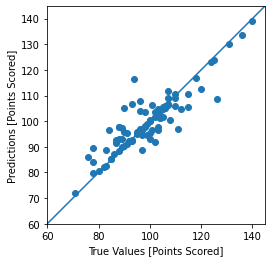

In [73]:
print(backup)
prediction_test = Prediction(backup)

prediction_test.test_prediction_accuracy()


In [79]:

#team =Team(1610612764) 
prediction_data = team.get_data_for_prediction("CHI")

print(prediction_data)
rohan = prediction_test.make_prediction(prediction_data)
print("The predicted score is", rohan)


22222
0     111
1     103
2      80
3     109
4     124
5     116
6     108
7      96
8     118
9     112
10    118
11     94
12    101
13     98
14    109
15    122
16    100
17    121
18    105
19    105
20     82
21     85
22    124
23     81
24    111
25    113
26    100
27    108
28    134
29    128
30    105
31    118
32     83
33    119
34     97
35    111
36    107
Name: PTS, dtype: int64
77777777777777777777777777777777777777777 [106.91891891891892]
   Matchup  Team Point Average  Opponent Team Point Average
0        5          106.918919                   114.714286
Here is the result
   Team Point Average  Opponent Team Point Average  ATL  BKN  BOS  CHA  CHI  \
0          106.918919                   114.714286  0.0  0.0  0.0  0.0  1.0   

   CLE  DAL  DEN  ...  OKC  ORL  PHI  PHX  POR  SAC  SAS  TOR  UTA  WAS  
0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[1 rows x 31 columns]
     Points Scored  Team Point Average  Opponent Team Point Average 

Epoch 105/1000
29/29 [==============================] - 0s 1ms/step - loss: 107.2744 - mae: 8.3667 - mse: 107.2744
Epoch 106/1000
29/29 [==============================] - 0s 1ms/step - loss: 114.0626 - mae: 8.6432 - mse: 114.0626
Epoch 107/1000
29/29 [==============================] - 0s 1ms/step - loss: 104.7873 - mae: 8.2304 - mse: 104.7873
Epoch 108/1000
29/29 [==============================] - 0s 1ms/step - loss: 104.4576 - mae: 8.3336 - mse: 104.4576
Epoch 109/1000
29/29 [==============================] - 0s 1ms/step - loss: 102.7420 - mae: 8.1447 - mse: 102.7420
Epoch 110/1000
29/29 [==============================] - 0s 1ms/step - loss: 112.7848 - mae: 8.5676 - mse: 112.7848
Epoch 111/1000
29/29 [==============================] - 0s 1ms/step - loss: 104.7413 - mae: 8.1842 - mse: 104.7413
Epoch 112/1000
29/29 [==============================] - 0s 1ms/step - loss: 106.8456 - mae: 8.3771 - mse: 106.8456
Epoch 113/1000
29/29 [==============================] - 0s 1ms/step - loss: 110.